In [1]:
## Required libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import shap
from sklearn.model_selection import KFold
from scipy.stats import pearsonr

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


class CFG:
    train_path = "/kaggle/input/drw-crypto-market-prediction/train.parquet"
    test_path = "/kaggle/input/drw-crypto-market-prediction/test.parquet"
    sample_sub_path = "/kaggle/input/drw-crypto-market-prediction/sample_submission.csv"

def reduce_mem_usage(dataframe, dataset):    
    print('Reducing memory usage for:', dataset)
    initial_mem_usage = dataframe.memory_usage().sum() / 1024**2
    
    for col in dataframe.columns:
        col_type = dataframe[col].dtype

        c_min = dataframe[col].min()
        c_max = dataframe[col].max()
        if str(col_type)[:3] == 'int':
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                dataframe[col] = dataframe[col].astype(np.int8)
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                dataframe[col] = dataframe[col].astype(np.int16)
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                dataframe[col] = dataframe[col].astype(np.int32)
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                dataframe[col] = dataframe[col].astype(np.int64)
        else:
            if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                dataframe[col] = dataframe[col].astype(np.float16)
            elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                dataframe[col] = dataframe[col].astype(np.float32)
            else:
                dataframe[col] = dataframe[col].astype(np.float64)

    final_mem_usage = dataframe.memory_usage().sum() / 1024**2
    print('--- Memory usage before: {:.2f} MB'.format(initial_mem_usage))
    print('--- Memory usage after: {:.2f} MB'.format(final_mem_usage))
    print('--- Decreased memory usage by {:.1f}%\n'.format(100 * (initial_mem_usage - final_mem_usage) / initial_mem_usage))

    return dataframe

# Create time-based sample weights
def create_time_weights(n_samples, decay_factor=0.95):
    """
    Create exponentially decaying weights based on sample position.
    More recent samples (higher indices) get higher weights.
    decay_factor controls the rate of decay (0.95 = 5% decay per time unit)
    """
    positions = np.arange(n_samples)
    # Normalize positions to [0, 1] range
    normalized_positions = positions / (n_samples - 1)
    # Apply exponential weighting
    weights = decay_factor ** (1 - normalized_positions)
    # Normalize weights to sum to n_samples (maintains scale)
    weights = weights * n_samples / weights.sum()
    return weights

/kaggle/input/drw-crypto-market-prediction/sample_submission.csv
/kaggle/input/drw-crypto-market-prediction/train.parquet
/kaggle/input/drw-crypto-market-prediction/test.parquet


In [3]:
# Load data
train = pd.read_parquet(CFG.train_path).reset_index(drop=True)
test = pd.read_parquet(CFG.test_path).reset_index(drop=True)
sample = pd.read_csv(CFG.sample_sub_path)

# Select features
selected_features = [
    "X863", "X856", "X344", "X598", "X862", "X385", "X852", "X603", "X860", "X674",
    "X415", "X345", "X137", "X855", "X174", "X302", "X178", "X532", "X168", "X612",
    "bid_qty", "ask_qty", "buy_qty", "sell_qty", "volume","X888", "X421", "X333"
]



train = train[selected_features + ["label"]]
test = test[selected_features]

train = reduce_mem_usage(train, "train")
test = reduce_mem_usage(test, "test")

print("Train=", train.shape)
print("Test=", test.shape)
print("Sample=", sample.shape)


Reducing memory usage for: train
--- Memory usage before: 116.35 MB
--- Memory usage after: 29.09 MB
--- Decreased memory usage by 75.0%

Reducing memory usage for: test
--- Memory usage before: 114.96 MB
--- Memory usage after: 28.74 MB
--- Decreased memory usage by 75.0%

Train= (525887, 29)
Test= (538150, 28)
Sample= (538150, 2)


In [4]:
RMV = ["label"]
FEATURES = [c for c in train.columns if c not in RMV]
print(f"There are {len(FEATURES)} FEATURES: {FEATURES}")

# Define cross-validation
FOLDS = 5
kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

# XGBoost parameters (same for all models)
xgb_params = {
    "tree_method": "gpu_hist",
    "colsample_bylevel": 0.4778015829774066,
    "colsample_bynode": 0.362764358742407,
    "colsample_bytree": 0.7107423488010493,
    "gamma": 1.7094857725240398,
    "learning_rate": 0.02213323588455387,
    "max_depth": 20,
    "max_leaves": 12,
    "min_child_weight": 16,
    "n_estimators": 1667,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 39.352415706891264,
    "reg_lambda": 75.44843704068275,
    "subsample": 0.06566669853471274,
    "verbosity": 0
}

There are 28 FEATURES: ['X863', 'X856', 'X344', 'X598', 'X862', 'X385', 'X852', 'X603', 'X860', 'X674', 'X415', 'X345', 'X137', 'X855', 'X174', 'X302', 'X178', 'X532', 'X168', 'X612', 'bid_qty', 'ask_qty', 'buy_qty', 'sell_qty', 'volume', 'X888', 'X421', 'X333']


In [5]:
lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.5625888953382505,
    "learning_rate": 0.029312951475451557,
    "min_child_samples": 63,
    "min_child_weight": 0.11456572852335424,
    "n_estimators": 126,
    "n_jobs": -1,
    "num_leaves": 37,
    "random_state": 42,
    "reg_alpha": 85.2476527854083,
    "reg_lambda": 99.38305361388907,
    "subsample": 0.450669817684892,
    "verbose": -1
}

In [6]:
# Initialize predictions for all three models
oof_preds_model1 = np.zeros(len(train))
test_preds_model1 = np.zeros(len(test))
oof_preds_model2 = np.zeros(len(train))
test_preds_model2 = np.zeros(len(test))
oof_preds_model3 = np.zeros(len(train))  
test_preds_model3 = np.zeros(len(test))   
oof_preds_model3_lb = np.zeros(len(train))  # NEW: Model 3 predictions
test_preds_model3_lb = np.zeros(len(test))   # NEW: Model 3 predictions


# Generate sample weights for Model 1 (full data)
sample_weights_full = create_time_weights(len(train), decay_factor=0.95)
print(f"\nModel 1 - Full data sample weights range: [{sample_weights_full.min():.4f}, {sample_weights_full.max():.4f}]")
print(f"Model 1 - Full data sample weights mean: {sample_weights_full.mean():.4f}")

# Calculate the cutoff for 75% most recent data
cutoff_idx_75 = int(len(train) * 0.25)
print(f"\nModel 2 - Using most recent {len(train) - cutoff_idx_75} samples (75% of data)")

# Calculate the cutoff for 50% most recent data
cutoff_idx_50 = int(len(train) * 0.50)  # NEW: 50% cutoff
print(f"\nModel 3 - Using most recent {len(train) - cutoff_idx_50} samples (50% of data)")


Model 1 - Full data sample weights range: [0.9746, 1.0259]
Model 1 - Full data sample weights mean: 1.0000

Model 2 - Using most recent 394416 samples (75% of data)

Model 3 - Using most recent 262944 samples (50% of data)


In [7]:
# Cross-validation loop
for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
    print("\n" + "#" * 50)
    print(f"### Fold {i + 1}")
    print("#" * 50)
    
    # ========== MODEL 1: FULL DATA WITH TIME WEIGHTS ==========
    print("\n--- Model 1: Full Data with Time Weights ---")
    
    X_train_m1 = train.iloc[train_idx][FEATURES]
    y_train_m1 = train.iloc[train_idx]["label"]
    X_valid = train.iloc[valid_idx][FEATURES]
    y_valid = train.iloc[valid_idx]["label"]
    X_test = test[FEATURES]
    
    # Extract sample weights for this fold's training data
    train_weights_m1 = sample_weights_full[train_idx]
    
    model1 = XGBRegressor(**xgb_params)
    model1.fit(
        X_train_m1, y_train_m1,
        sample_weight=train_weights_m1,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=200
    )
    
    oof_preds_model1[valid_idx] = model1.predict(X_valid)
    test_preds_model1 += model1.predict(X_test)
    
    # ========== MODEL 2: 75% MOST RECENT DATA ==========
    print("\n--- Model 2: 75% Most Recent Data ---")
    
    # Filter train indices to only include those from the recent 75% of data
    train_idx_recent_75 = train_idx[train_idx >= cutoff_idx_75]
    
    # Adjust indices to start from 0 for the recent subset
    train_idx_recent_adjusted_75 = train_idx_recent_75 - cutoff_idx_75
    
    # Get the recent subset of training data
    train_recent_75 = train.iloc[cutoff_idx_75:].reset_index(drop=True)
    
    X_train_m2 = train_recent_75.iloc[train_idx_recent_adjusted_75][FEATURES]
    y_train_m2 = train_recent_75.iloc[train_idx_recent_adjusted_75]["label"]
    
    # Create time weights for the recent data subset
    sample_weights_recent_75 = create_time_weights(len(train_recent_75), decay_factor=0.95)
    train_weights_m2 = sample_weights_recent_75[train_idx_recent_adjusted_75]
    
    model2 = XGBRegressor(**xgb_params)
    model2.fit(
        X_train_m2, y_train_m2,
        sample_weight=train_weights_m2,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=200
    )
    
    # For validation predictions, we need to handle cases where validation indices
    # might be from the older 25% of data
    valid_idx_in_range_75 = valid_idx[valid_idx >= cutoff_idx_75]
    if len(valid_idx_in_range_75) > 0:
        X_valid_m2 = train.iloc[valid_idx_in_range_75][FEATURES]
        oof_preds_model2[valid_idx_in_range_75] = model2.predict(X_valid_m2)
    
    # For indices before cutoff, use Model 1 predictions
    valid_idx_out_range_75 = valid_idx[valid_idx < cutoff_idx_75]
    if len(valid_idx_out_range_75) > 0:
        oof_preds_model2[valid_idx_out_range_75] = oof_preds_model1[valid_idx_out_range_75]
    
    test_preds_model2 += model2.predict(X_test)
    
    # ========== MODEL 3: 50% MOST RECENT DATA ========== NEW
    print("\n--- Model 3: 50% Most Recent Data ---")
    
    # Filter train indices to only include those from the recent 50% of data
    train_idx_recent_50 = train_idx[train_idx >= cutoff_idx_50]
    
    # Adjust indices to start from 0 for the recent subset
    train_idx_recent_adjusted_50 = train_idx_recent_50 - cutoff_idx_50
    
    # Get the recent subset of training data
    train_recent_50 = train.iloc[cutoff_idx_50:].reset_index(drop=True)
    
    X_train_m3 = train_recent_50.iloc[train_idx_recent_adjusted_50][FEATURES]
    y_train_m3 = train_recent_50.iloc[train_idx_recent_adjusted_50]["label"]
    
    # Create time weights for the recent data subset
    sample_weights_recent_50 = create_time_weights(len(train_recent_50), decay_factor=0.95)
    train_weights_m3 = sample_weights_recent_50[train_idx_recent_adjusted_50]
    
    model3 = XGBRegressor(**xgb_params)
    model3.fit(
        X_train_m3, y_train_m3,
        sample_weight=train_weights_m3,
        eval_set=[(X_valid, y_valid)],
        early_stopping_rounds=25,
        verbose=200
    )
    
    # For validation predictions, we need to handle cases where validation indices
    # might be from the older 50% of data
    valid_idx_in_range_50 = valid_idx[valid_idx >= cutoff_idx_50]
    if len(valid_idx_in_range_50) > 0:
        X_valid_m3 = train.iloc[valid_idx_in_range_50][FEATURES]
        oof_preds_model3[valid_idx_in_range_50] = model3.predict(X_valid_m3)
    
    # For indices before cutoff, use Model 1 predictions
    valid_idx_out_range_50 = valid_idx[valid_idx < cutoff_idx_50]
    if len(valid_idx_out_range_50) > 0:
        oof_preds_model3[valid_idx_out_range_50] = oof_preds_model1[valid_idx_out_range_50]
    
    test_preds_model3 += model3.predict(X_test)

    # ========== MODEL 3: 50% MOST RECENT DATA  LGBM========== NEW
    print("\n--- Model 3: 50% Most Recent Data with LGBM ---")
    
    model3_lb = LGBMRegressor(**lgbm_params)
    model3_lb.fit(
        X_train_m3, y_train_m3,
        sample_weight=train_weights_m3,
        eval_set=[(X_valid, y_valid)]
    )
    
    # For validation predictions, we need to handle cases where validation indices
    # might be from the older 50% of data
    valid_idx_in_range_50 = valid_idx[valid_idx >= cutoff_idx_50]
    if len(valid_idx_in_range_50) > 0:
        X_valid_m3 = train.iloc[valid_idx_in_range_50][FEATURES]
        oof_preds_model3_lb[valid_idx_in_range_50] = model3_lb.predict(X_valid_m3)
    
    # For indices before cutoff, use Model 1 predictions
    valid_idx_out_range_50 = valid_idx[valid_idx < cutoff_idx_50]
    if len(valid_idx_out_range_50) > 0:
        oof_preds_model3_lb[valid_idx_out_range_50] = oof_preds_model1[valid_idx_out_range_50]
    
    test_preds_model3_lb += model3_lb.predict(X_test)

# Average test predictions across folds
test_preds_model1 /= FOLDS
test_preds_model2 /= FOLDS
test_preds_model3 /= FOLDS  # NEW
test_preds_model3_lb /= FOLDS  # NEW

# Calculate individual model scores
pearson_score_model1 = pearsonr(train["label"], oof_preds_model1)[0]
pearson_score_model2 = pearsonr(train["label"], oof_preds_model2)[0]
pearson_score_model3 = pearsonr(train["label"], oof_preds_model3)[0]  
pearson_score_model3_lb = pearsonr(train["label"], oof_preds_model3_lb)[0]  # NEW

print("\n" + "=" * 50)
print("INDIVIDUAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Model 1 (Full Data) Pearson Correlation: {pearson_score_model1:.4f}")
print(f"Model 2 (75% Recent) Pearson Correlation: {pearson_score_model2:.4f}")
print(f"Model 3 XB (50% Recent) Pearson Correlation: {pearson_score_model3:.4f}")  # NEW
print(f"Model 3 LB (50% Recent) Pearson Correlation: {pearson_score_model3_lb:.4f}")  # NEW


##################################################
### Fold 1
##################################################

--- Model 1: Full Data with Time Weights ---


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-rmse:1.01616
[200]	validation_0-rmse:0.98197
[400]	validation_0-rmse:0.96175
[600]	validation_0-rmse:0.94619
[800]	validation_0-rmse:0.93220
[1000]	validation_0-rmse:0.92138
[1200]	validation_0-rmse:0.91115
[1400]	validation_0-rmse:0.90212
[1600]	validation_0-rmse:0.89412
[1666]	validation_0-rmse:0.89152

--- Model 2: 75% Most Recent Data ---
[0]	validation_0-rmse:1.01616


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.98542
[400]	validation_0-rmse:0.96637
[600]	validation_0-rmse:0.95276
[800]	validation_0-rmse:0.94093
[1000]	validation_0-rmse:0.93169
[1200]	validation_0-rmse:0.92350
[1400]	validation_0-rmse:0.91642
[1600]	validation_0-rmse:0.91016
[1666]	validation_0-rmse:0.90832

--- Model 3: 50% Most Recent Data ---
[0]	validation_0-rmse:1.01686


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.99025
[400]	validation_0-rmse:0.97501
[600]	validation_0-rmse:0.96422
[800]	validation_0-rmse:0.95557
[1000]	validation_0-rmse:0.94906
[1200]	validation_0-rmse:0.94342
[1400]	validation_0-rmse:0.93873
[1600]	validation_0-rmse:0.93468
[1666]	validation_0-rmse:0.93352

--- Model 3: 50% Most Recent Data with LGBM ---

##################################################
### Fold 2
##################################################

--- Model 1: Full Data with Time Weights ---
[0]	validation_0-rmse:1.01401


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.98154
[400]	validation_0-rmse:0.96055
[600]	validation_0-rmse:0.94466
[800]	validation_0-rmse:0.93176
[1000]	validation_0-rmse:0.91989
[1200]	validation_0-rmse:0.90951
[1400]	validation_0-rmse:0.90048
[1600]	validation_0-rmse:0.89186
[1666]	validation_0-rmse:0.88953

--- Model 2: 75% Most Recent Data ---
[0]	validation_0-rmse:1.01403


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.98272
[400]	validation_0-rmse:0.96407
[600]	validation_0-rmse:0.94987
[800]	validation_0-rmse:0.93900
[1000]	validation_0-rmse:0.92948
[1200]	validation_0-rmse:0.92107
[1400]	validation_0-rmse:0.91374
[1600]	validation_0-rmse:0.90701
[1666]	validation_0-rmse:0.90507

--- Model 3: 50% Most Recent Data ---
[0]	validation_0-rmse:1.01446


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.98845
[400]	validation_0-rmse:0.97355
[600]	validation_0-rmse:0.96342
[800]	validation_0-rmse:0.95522
[1000]	validation_0-rmse:0.94901
[1200]	validation_0-rmse:0.94351
[1400]	validation_0-rmse:0.93928
[1600]	validation_0-rmse:0.93562
[1666]	validation_0-rmse:0.93444

--- Model 3: 50% Most Recent Data with LGBM ---

##################################################
### Fold 3
##################################################

--- Model 1: Full Data with Time Weights ---
[0]	validation_0-rmse:1.00215


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.96993
[400]	validation_0-rmse:0.94960
[600]	validation_0-rmse:0.93416
[800]	validation_0-rmse:0.92163
[1000]	validation_0-rmse:0.91028
[1200]	validation_0-rmse:0.90027
[1400]	validation_0-rmse:0.89136
[1600]	validation_0-rmse:0.88349
[1666]	validation_0-rmse:0.88095

--- Model 2: 75% Most Recent Data ---
[0]	validation_0-rmse:1.00226


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.97157
[400]	validation_0-rmse:0.95272
[600]	validation_0-rmse:0.93928
[800]	validation_0-rmse:0.92774
[1000]	validation_0-rmse:0.91828
[1200]	validation_0-rmse:0.90980
[1400]	validation_0-rmse:0.90263
[1600]	validation_0-rmse:0.89696
[1666]	validation_0-rmse:0.89512

--- Model 3: 50% Most Recent Data ---
[0]	validation_0-rmse:1.00300


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.97682
[400]	validation_0-rmse:0.96222
[600]	validation_0-rmse:0.95077
[800]	validation_0-rmse:0.94229
[1000]	validation_0-rmse:0.93549
[1200]	validation_0-rmse:0.93011
[1400]	validation_0-rmse:0.92571
[1600]	validation_0-rmse:0.92160
[1666]	validation_0-rmse:0.92051

--- Model 3: 50% Most Recent Data with LGBM ---

##################################################
### Fold 4
##################################################

--- Model 1: Full Data with Time Weights ---
[0]	validation_0-rmse:1.01679


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.98302
[400]	validation_0-rmse:0.96295
[600]	validation_0-rmse:0.94691
[800]	validation_0-rmse:0.93379
[1000]	validation_0-rmse:0.92233
[1200]	validation_0-rmse:0.91224
[1400]	validation_0-rmse:0.90257
[1600]	validation_0-rmse:0.89439
[1666]	validation_0-rmse:0.89151

--- Model 2: 75% Most Recent Data ---
[0]	validation_0-rmse:1.01684


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.98523
[400]	validation_0-rmse:0.96656
[600]	validation_0-rmse:0.95219
[800]	validation_0-rmse:0.94047
[1000]	validation_0-rmse:0.93120
[1200]	validation_0-rmse:0.92296
[1400]	validation_0-rmse:0.91579
[1600]	validation_0-rmse:0.90946
[1666]	validation_0-rmse:0.90750

--- Model 3: 50% Most Recent Data ---
[0]	validation_0-rmse:1.01734


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.99162
[400]	validation_0-rmse:0.97646
[600]	validation_0-rmse:0.96537
[800]	validation_0-rmse:0.95741
[1000]	validation_0-rmse:0.95138
[1200]	validation_0-rmse:0.94627
[1400]	validation_0-rmse:0.94202
[1600]	validation_0-rmse:0.93803
[1666]	validation_0-rmse:0.93701

--- Model 3: 50% Most Recent Data with LGBM ---

##################################################
### Fold 5
##################################################

--- Model 1: Full Data with Time Weights ---
[0]	validation_0-rmse:0.99904


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.96578
[400]	validation_0-rmse:0.94526
[600]	validation_0-rmse:0.92986
[800]	validation_0-rmse:0.91657
[1000]	validation_0-rmse:0.90519
[1200]	validation_0-rmse:0.89518
[1400]	validation_0-rmse:0.88607
[1600]	validation_0-rmse:0.87818
[1666]	validation_0-rmse:0.87582

--- Model 2: 75% Most Recent Data ---
[0]	validation_0-rmse:0.99901


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.96742
[400]	validation_0-rmse:0.94936
[600]	validation_0-rmse:0.93556
[800]	validation_0-rmse:0.92392
[1000]	validation_0-rmse:0.91439
[1200]	validation_0-rmse:0.90647
[1400]	validation_0-rmse:0.89916
[1600]	validation_0-rmse:0.89309
[1666]	validation_0-rmse:0.89121

--- Model 3: 50% Most Recent Data ---
[0]	validation_0-rmse:0.99955


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[200]	validation_0-rmse:0.97400
[400]	validation_0-rmse:0.95979
[600]	validation_0-rmse:0.94890
[800]	validation_0-rmse:0.94051
[1000]	validation_0-rmse:0.93401
[1200]	validation_0-rmse:0.92893
[1400]	validation_0-rmse:0.92473
[1600]	validation_0-rmse:0.92094
[1666]	validation_0-rmse:0.92010

--- Model 3: 50% Most Recent Data with LGBM ---

INDIVIDUAL MODEL PERFORMANCE
Model 1 (Full Data) Pearson Correlation: 0.5411
Model 2 (75% Recent) Pearson Correlation: 0.5657
Model 3 XB (50% Recent) Pearson Correlation: 0.5824
Model 3 LB (50% Recent) Pearson Correlation: 0.6249


In [8]:
# Create ensemble predictions
# Simple average ensemble (now with 3 models)
ensemble_oof_preds = (oof_preds_model1 + oof_preds_model2 + oof_preds_model3 + oof_preds_model3_lb) / 4  # UPDATED
ensemble_test_preds = (test_preds_model1 + test_preds_model2 + test_preds_model3 + test_preds_model3_lb) / 4  # UPDATED

# Calculate ensemble score
ensemble_pearson_score = pearsonr(train["label"], ensemble_oof_preds)[0]

print("\n" + "=" * 50)
print("ENSEMBLE PERFORMANCE")
print("=" * 50)
print(f"Ensemble (Equal Weight) Pearson Correlation: {ensemble_pearson_score:.4f}")

# Performance-weighted ensemble (now with 3 models)
total_score = pearson_score_model1 + pearson_score_model2 + pearson_score_model3+ pearson_score_model3_lb  # UPDATED
weight_model1 = pearson_score_model1 / total_score  # UPDATED
weight_model2 = pearson_score_model2 / total_score  # UPDATED
weight_model3 = pearson_score_model3 / total_score  # NEW
weight_model3_lb = pearson_score_model3_lb / total_score  # NEW

weighted_ensemble_oof = (weight_model1 * oof_preds_model1 + 
                        weight_model2 * oof_preds_model2 + 
                        weight_model3 * oof_preds_model3 + 
                        weight_model3_lb * oof_preds_model3_lb)  # UPDATED
weighted_ensemble_test = (weight_model1 * test_preds_model1 + 
                         weight_model2 * test_preds_model2 + 
                         weight_model3 * test_preds_model3  + 
                         weight_model3_lb * test_preds_model3_lb)  # UPDATED

weighted_ensemble_score = pearsonr(train["label"], weighted_ensemble_oof)[0]

print(f"\nWeighted Ensemble Performance:")
print(f"  Model 1 weight: {weight_model1:.3f}")
print(f"  Model 2 weight: {weight_model2:.3f}")
print(f"  Model 3 weight: {weight_model3:.3f}")  # NEW
print(f"  Model 3 weight: {weight_model3_lb:.3f}")  # NEW
print(f"  Weighted Ensemble Pearson Correlation: {weighted_ensemble_score:.4f}")

# Use the better ensemble for final predictions
if weighted_ensemble_score > ensemble_pearson_score:
    final_test_preds = weighted_ensemble_test
    print("\nUsing weighted ensemble for final predictions")
else:
    final_test_preds = ensemble_test_preds
    print("\nUsing simple average ensemble for final predictions")



ENSEMBLE PERFORMANCE
Ensemble (Equal Weight) Pearson Correlation: 0.5935

Weighted Ensemble Performance:
  Model 1 weight: 0.234
  Model 2 weight: 0.244
  Model 3 weight: 0.252
  Model 3 weight: 0.270
  Weighted Ensemble Pearson Correlation: 0.5954

Using weighted ensemble for final predictions



Generating SHAP analysis for model 1...


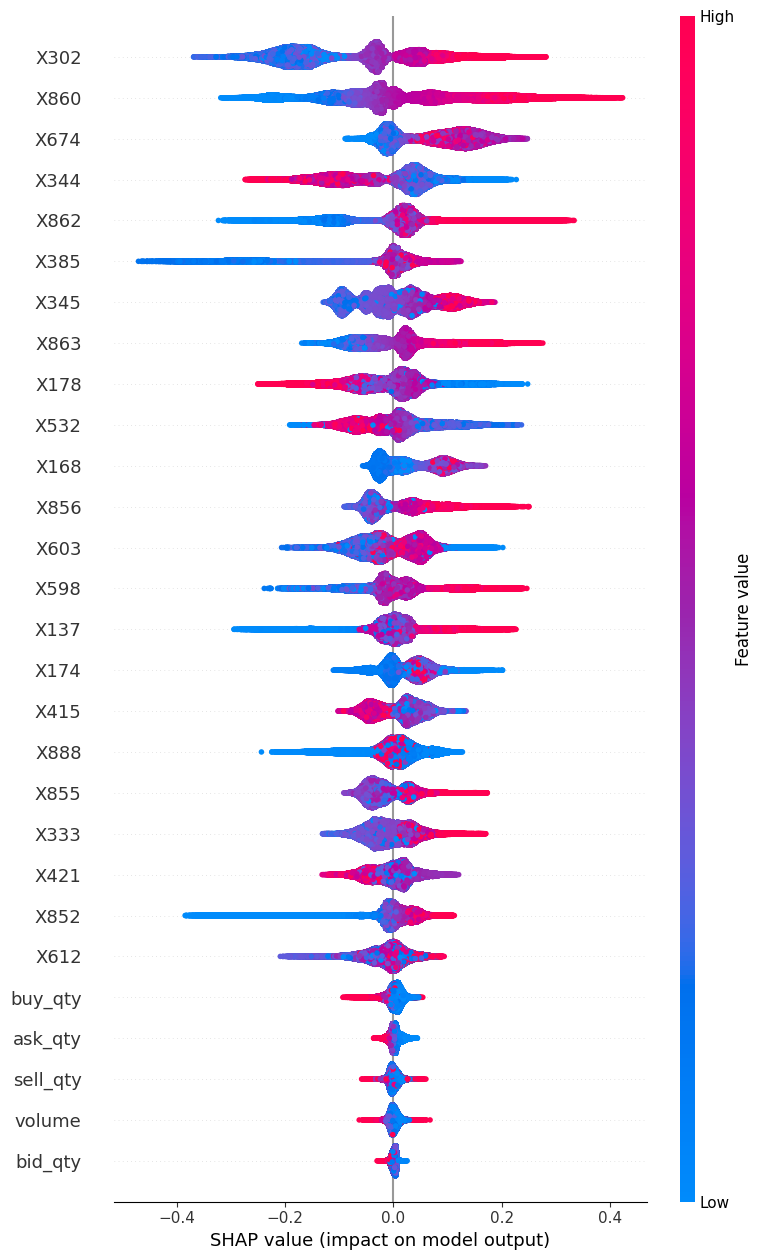

In [9]:
# SHAP analysis (using Model 1 as representative)
print("\nGenerating SHAP analysis for model 1...")
explainer = shap.TreeExplainer(model1, feature_perturbation="tree_path_dependent", model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)


Generating SHAP analysis for model 2...


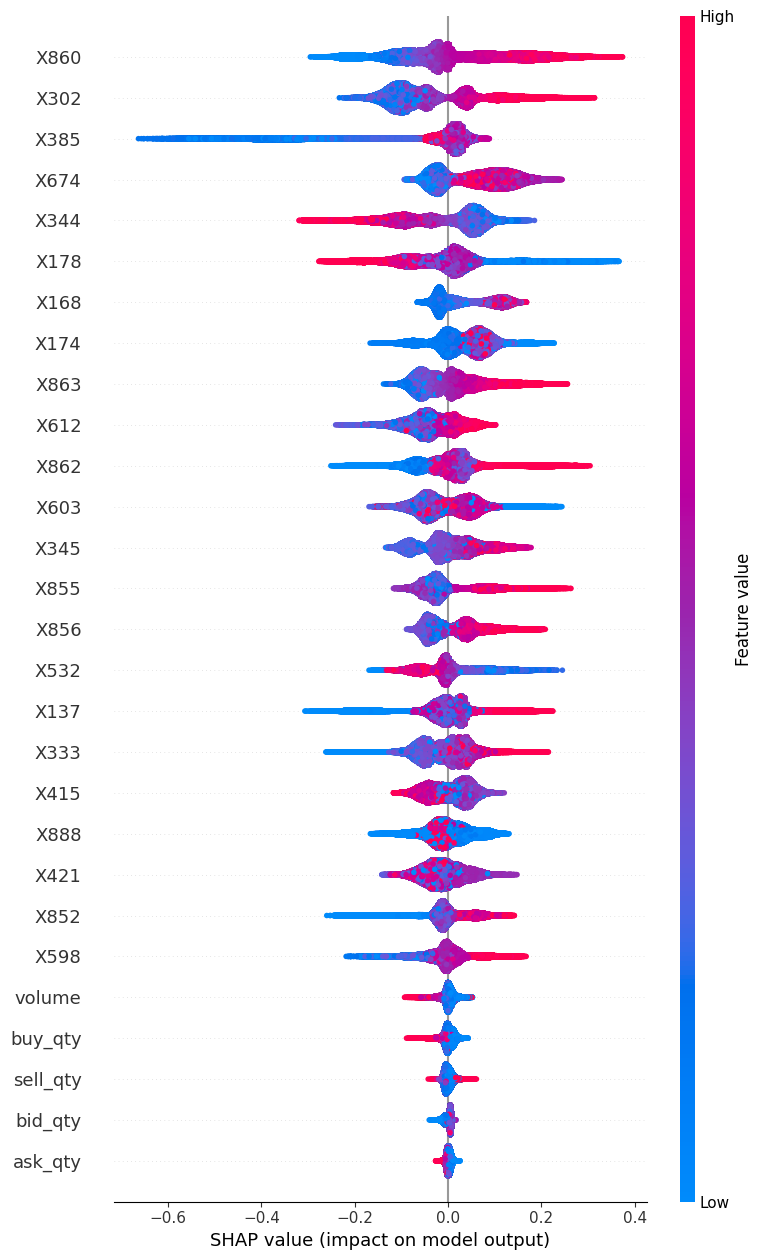

In [10]:
# SHAP analysis (using Model 1 as representative)
print("\nGenerating SHAP analysis for model 2...")
explainer = shap.TreeExplainer(model2, feature_perturbation="tree_path_dependent", model_output="raw")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=30)

In [11]:
# Save predictions
sample["prediction"] = final_test_preds
sample.to_csv("submission.csv", index=False)
print("\nPredictions saved to submission.csv")
print(sample.head())

# Save detailed results (now with 3 models)
ensemble_results = pd.DataFrame({
    'model': ['Model 1 (Full Data)', 'Model 2 (75% Recent)', 'Model 3 (50% Recent)', 
              'Simple Ensemble', 'Weighted Ensemble'],  # UPDATED
    'pearson_correlation': [pearson_score_model1, pearson_score_model2, pearson_score_model3, 
                           ensemble_pearson_score, weighted_ensemble_score],  # UPDATED
    'weight_in_final': [weight_model1 if weighted_ensemble_score > ensemble_pearson_score else 1/3,
                        weight_model2 if weighted_ensemble_score > ensemble_pearson_score else 1/3,
                        weight_model3 if weighted_ensemble_score > ensemble_pearson_score else 1/3,
                        np.nan, np.nan]  # UPDATED
})
ensemble_results.to_csv("ensemble_results.csv", index=False)
print("\nEnsemble results saved to ensemble_results.csv")
print(ensemble_results)


Predictions saved to submission.csv
   ID  prediction
0   1    0.183916
1   2    0.151443
2   3    0.177853
3   4    0.002551
4   5    0.212350

Ensemble results saved to ensemble_results.csv
                  model  pearson_correlation  weight_in_final
0   Model 1 (Full Data)             0.541080         0.233820
1  Model 2 (75% Recent)             0.565734         0.244474
2  Model 3 (50% Recent)             0.582359         0.251658
3       Simple Ensemble             0.593515              NaN
4     Weighted Ensemble             0.595389              NaN


invalid value encountered in greater
invalid value encountered in less
invalid value encountered in greater
